## Analyse A/B Test Results

#### By Joel Chua

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

The notebook will explore three main approaches, probability, A/B testing and regression to help make a decision on the old or new webpage

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
#setting the seed for reproducability
random.seed(42)

In [2]:
# Reading in the dataset 
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


---
Let's start with some exploration of the dataset 

In [3]:
df.shape

(294478, 5)

In [4]:
df.user_id.nunique()

290584

In [5]:
# checking for missing rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
# percentage users who convert regardless of landing page
df['converted'].mean()

0.11965919355605512

In [7]:
# The number of times the `new_page` and `treatment` don't match
con_new = len(df.query("group == 'control' & landing_page == 'new_page'"))
treat_old = len(df.query("group == 'treatment' & landing_page == 'old_page'"))
con_new + treat_old 

3893

In [8]:
# Removing the rows where the page and treatmetn dont match - saving it in a new df
df2 = df.query("group == 'control' & landing_page == 'old_page'")
df2 = df2.append(df.query("group == 'treatment' & landing_page == 'new_page'"))

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

---
Now let's explore our new clean DataFrame

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# Checking for duplicated entries
df2['user_id'].duplicated()

0         False
1         False
4         False
5         False
7         False
          ...  
294462    False
294465    False
294468    False
294472    False
294477    False
Name: user_id, Length: 290585, dtype: bool

In [12]:
# Finding the duplicated entry
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:

df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# dropping one of the entries
df2.drop(2893, axis=0, inplace=True)

---
a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df['converted'].mean()

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
len(df2[df2['landing_page']=='new_page'])/len(df2)

0.5000619442226688

From the above (a) to (d), we can make some simple observations. The average convertion rate across all groups is 11.97%; with the distrubution of participants being close to 50% between control and treatment groups. The convertion rates of both the control and treatment groups are silmilar, at 12.04% and 11.88% respectively. This would lead us to believe that the control group has slightly more convertions, but this is not enough evidence to come to a difinitive conclusion.

<a id='ab_test'></a>
### Part II - A/B Test

For now, we will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. With **$p_{old}$** and **$p_{new}$**, as the converted rates for the old and new pages, the null and alternative hypothesis are as follows:

 <center> $H_{0}$ : $p_{old}$ ≥ $p_{new}$ </center>
 
 <center> $H_{1}$ :  $p_{old}$ < $p_{new}$ </center>
 


Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will use a sample size for each page equal to the ones in **ab_data.csv** and perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. The **conversion rate** for $p_{new}$ under the null?

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null?

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. The number of users in treatment and control

In [21]:
# Number of users in treatment and control
n_new = df2.query("group == 'treatment'")['user_id'].nunique()
n_old = df2.query("group == 'control'")['user_id'].nunique()
print(n_new,n_old)

145310 145274


e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:

new_page_converted = np.random.choice([1,0], size=n_new, replace=True, p=(p_new, 1-p_new))
new_page_converted.mean()

0.11980593214506917

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([1,0], size=n_old, replace = True, p=(p_old, 1-p_old))
old_page_converted.mean()

0.11880308933463662

g. Let's find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
pages_diff = new_page_converted.mean() - old_page_converted.mean()

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
# creating an array
p_diffs = []

# simulating 10,000 random 'conversions'
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted


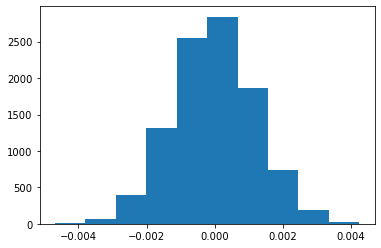

In [26]:
# Histogram to visualise the simulation 
plt.hist(p_diffs);

Let's simulate the distribution under the null hypothesis

0.1994

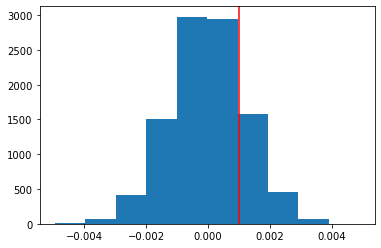

In [27]:
#converting p_diffs to ndarray
p_diffs = np.array(p_diffs)

# simulating distrubution under the null, centered at 0
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.hist(null_vals)
plt.axvline(x=pages_diff, color='red');

#p-value
(null_vals > pages_diff).mean()

* Abov, we simulated distribution under the null hypothesis, by creating a random normal distribution centred at 0.  
* By comparing the observed difference (pages_diff) against the null distribution to find the p-value. 
* From this, we can observe, as the p-value lies outside 5% type 1 error rate. 
* Thus, in this case, we fail to reject the null hypothesis. We should assume that the old page does as well, or better than the new page.


---
We could also use a built-in to achieve similar results. Next, we will explore it visa the tools from the statsmodels library. 

In [28]:
import statsmodels.api as sm

convert_old = len(df2.query("landing_page == 'old_page' & converted == 1"))
convert_new = len(df2.query("landing_page == 'new_page' & converted == 1"))
n_old = df2['landing_page'].value_counts()[1]
n_new = df2['landing_page'].value_counts()[0]

m. Using `stats.proportions_ztest` to compute your test statistic and p-value.

In [29]:
# calculating the z_test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='smaller')
z_score, p_value

# calculating the critical z_term
z_crit = norm.ppf(1-0.05)

print( 'P-Value: ', p_value, '\nZ-Score: ', z_score, '\nCritical Z-Score: ',z_crit)

P-Value:  0.9050583127590245 
Z-Score:  1.3109241984234394 
Critical Z-Score:  1.6448536269514722


* The z-score of 1.311 is less than the critical z-score of 1.645
* The p-value of  0.9050 also lies outside of the 5% type 1 error interval
* Thus, like in parts **j.** and **k.**, we fail to reject the null hypothesis

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will attempt to replicate the result we observed in the A/B test in Part II through a regression approach.<br><br> 

Since each row is either a conversion or no conversion, which is a binary events, we will use logistic regression

The goal is to use **statsmodels** to fit the regression model earlier, to see if there is a significant difference in conversion based on which page a customer receives. However, we will first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# creating a copy of df2 to work with
df_log = df2.copy()
df_log.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [31]:
# adding the intercept column 
df_log['intercept'] = 1

# creating the dummy variables
df_log[['control', 'ab_page']] = pd.get_dummies(df["group"])
df_log.drop("control", axis=1, inplace=True)
df_log.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Use **statsmodels** to instantiate the regression model on the two columns you created previously, then fit the model using the two columns you created previously to predict whether or not an individual converts. 

In [32]:
log_mod = sm.Logit(df_log['converted'], df_log[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 Jul 2021   Pseudo R-squ.:               8.077e-06
Time:                        20:03:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [33]:
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

* Holding all other variables constant; the number of convertions from the new page is 1.015 times more likely to lead to to a convertion than those who did not convert. 

**Observations:**

* The p-value found was 0.1899, which was different from the precious section.
* A reason for the difference, is that the current logistic regression takes a two-tailed p-test, while a single-tailed test was done in the previous sections.
* The p-value returned is greater than than the 5% type one error interval, as such we fail to reject the null hypothesis

 Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

* Adding other factors allow us to be able to look into the relation ship between these independent variables and how they relate to the convertion
* However, adding too many factors can lead to over-fitting. 
* Aslo, it id vital to ensure that there are no multicollinearity issues when adding new independent variables

To explore how new factors might affect the results of a regression model, we will  read in the **countries.csv** dataset and merge together the datasets on the appropriate rows.

In [34]:
# reading in countries.csv
df_c = pd.read_csv('countries.csv')

# merging the countries df into the existing df 
df3 = pd.merge(df_log, df_c, on='user_id', how='right') 

# creating country dummy variable
df3 = df3.join(pd.get_dummies(df3['country']))
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,UK,0,1,0
1,928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,US,0,0,1
2,822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,UK,0,1,0
3,711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,UK,0,1,0
4,710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,UK,0,1,0


In [35]:
# fitting the Logistic Regression Model & results
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
results = log_mod.fit() 
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 02 Jul 2021   Pseudo R-squ.:               2.323e-05
Time:                        20:03:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [36]:
results.params

intercept   -1.989272
ab_page     -0.014943
CA          -0.040757
UK           0.009883
dtype: float64

In [37]:
np.exp(results.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [38]:
1/np.exp(results.params)

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64

* The p-values for all the countries variables, excede the 5% type one error interval, as such we fail to reject the null hypothesis. 

* Fruthermore, the coef. values show that the different countries have a similar convertion rate, with CA and UK being 1.042 and 1.010 times more likely, to convert if the user is from the respective country; with all other variables kep constant. 


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
# Creating the higher order page and country column
df3['US_ab_page'] = df3['US'] * df3['ab_page']
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_ab_page,CA_ab_page
0,834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,UK,0,1,0,0,0
1,928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,US,0,0,1,1,0
2,822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,UK,0,1,0,0,0
3,711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,UK,0,1,0,0,0
4,710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,UK,0,1,0,0,0


In [40]:
# fitting the Logistic Regression Model & Results
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'US_ab_page', 'CA_ab_page']])
results = log_mod.fit() 
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 02 Jul 2021   Pseudo R-squ.:               3.482e-05
Time:                        20:03:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

From the test results above, we can observe that:
* Both 'US_ab_page' and 'CA_ab_page', have p-values of 0.238 and 0.057 respectively. 
* Both values exceed type 1 error rate of 5%, as such, we fail to reject the null hypothesis 

In conclusion, looking that the different tests conducted above, it is safe to say that there is **insufficient evidence** to suggest that the new page leads to more conversions over the old page. As in the tests above, we repeatedly **fail to reject the null hypothesis**.